# 개인미션풀이

## 1. 활성화 함수 선택 기능 추가 및 성능 비교

In [1]:
import numpy as np

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = x <= 0
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dx = dout.copy()
        dx[self.mask] = 0
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

def cross_entropy_error(p, r):
    delta = 1e-7
    batch_size = p.shape[0]
    total_loss = -np.sum(r * np.log(p + delta))
    return total_loss / batch_size                               # 평균으로 맞춰줌

def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in np.ndindex(x.shape):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(x)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

def softmax(x):
    if x.ndim == 1:
        c = np.max(x)
        exp_a = np.exp(x-c)
        sum_exp_a = np.sum(exp_a)
        y = exp_a / sum_exp_a
        return y
    elif x.ndim == 2:
        c = np.max(x, axis = 1).reshape(-1, 1)
        exp_a = np.exp(x - c)
        sum_exp_a = np.sum(exp_a, axis = 1).reshape(-1, 1)
        y = exp_a / sum_exp_a
        return y

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

class Affine:
    def __init__(self, w, b):
        self.w = w
        self.b = b
        self.x = None
        self.dw = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = x @ self.w + self.b
        return out

    def backward(self, dout):
        dx = dout @ self.w.T
        self.dw = self.x.T @ dout
        self.db = np.sum(dout, axis = 0)
        return dx


### - Relu

In [ ]:
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, I, H, O):
        self.params = {}
        self.params['w1'] = np.random.randn(I, H)
        self.params['b1'] = np.random.randn(H)
        self.params['w2'] = np.random.randn(H, O)
        self.params['b2'] = np.random.randn(O)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for i in self.layers.values():
            x = i.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1:
            t = np.argmax(t, axis = 1)
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for i in layers:
            dout = i.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        return grads

In [4]:
import pickle
f = open("Data/mnist.dat", 'rb')
train, test = pickle.load(f)
f.close()

train_x, train_y = train
test_x, test_y = test

train_scaled = train_x.reshape(-1, 28*28) / 255
test_scaled = test_x.reshape(-1, 28*28) / 255

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_y = encoder.fit_transform(train_y.reshape(-1, 1)).toarray()
test_y = encoder.fit_transform(test_y.reshape(-1, 1)).toarray()

train_size = len(train_scaled)
batch_size = 100
lr = 0.1

net = TwoLayerNet(784, 50, 10)

train_losses = []
test_losses = []

train_acc = []
test_acc = []

In [5]:
for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    for key in ('w1', 'b1', 'w2', 'b2'):
        net.params[key] -= grad[key] * lr

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 100 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

100회 학습 / 정확도(훈련) : 0.650, 정확도(시험) : 0.656
200회 학습 / 정확도(훈련) : 0.699, 정확도(시험) : 0.700
300회 학습 / 정확도(훈련) : 0.715, 정확도(시험) : 0.717
400회 학습 / 정확도(훈련) : 0.737, 정확도(시험) : 0.740
500회 학습 / 정확도(훈련) : 0.753, 정확도(시험) : 0.755
600회 학습 / 정확도(훈련) : 0.763, 정확도(시험) : 0.762
700회 학습 / 정확도(훈련) : 0.777, 정확도(시험) : 0.780
800회 학습 / 정확도(훈련) : 0.789, 정확도(시험) : 0.793
900회 학습 / 정확도(훈련) : 0.782, 정확도(시험) : 0.784
1000회 학습 / 정확도(훈련) : 0.801, 정확도(시험) : 0.805


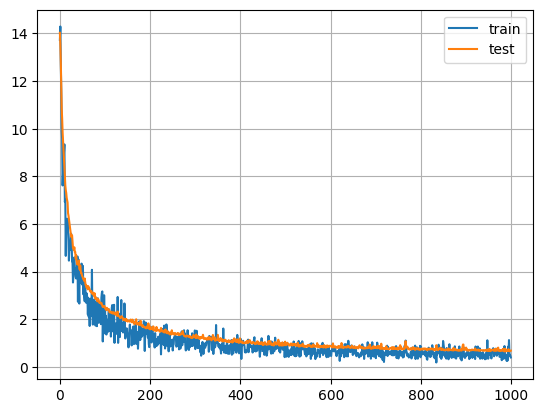

In [4]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.grid()
plt.show()

### - sigmoid

In [6]:
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, I, H, O):
        self.params = {}
        self.params['w1'] = np.random.randn(I, H)
        self.params['b1'] = np.random.randn(H)
        self.params['w2'] = np.random.randn(H, O)
        self.params['b2'] = np.random.randn(O)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Sigmoid'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for i in self.layers.values():
            x = i.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1:
            t = np.argmax(t, axis = 1)
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for i in layers:
            dout = i.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        return grads

In [7]:
import pickle
f = open("Data/mnist.dat", 'rb')
train, test = pickle.load(f)
f.close()

train_x, train_y = train
test_x, test_y = test

train_scaled = train_x.reshape(-1, 28*28) / 255
test_scaled = test_x.reshape(-1, 28*28) / 255

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_y = encoder.fit_transform(train_y.reshape(-1, 1)).toarray()
test_y = encoder.fit_transform(test_y.reshape(-1, 1)).toarray()

train_size = len(train_scaled)
batch_size = 100
lr = 0.1

net = TwoLayerNet(784, 50, 10)

train_losses = []
test_losses = []

train_acc = []
test_acc = []

for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    for key in ('w1', 'b1', 'w2', 'b2'):
        net.params[key] -= grad[key] * lr

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 100 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

100회 학습 / 정확도(훈련) : 0.275, 정확도(시험) : 0.279
200회 학습 / 정확도(훈련) : 0.431, 정확도(시험) : 0.437
300회 학습 / 정확도(훈련) : 0.529, 정확도(시험) : 0.535
400회 학습 / 정확도(훈련) : 0.592, 정확도(시험) : 0.599
500회 학습 / 정확도(훈련) : 0.638, 정확도(시험) : 0.643
600회 학습 / 정확도(훈련) : 0.671, 정확도(시험) : 0.679
700회 학습 / 정확도(훈련) : 0.697, 정확도(시험) : 0.708
800회 학습 / 정확도(훈련) : 0.718, 정확도(시험) : 0.727
900회 학습 / 정확도(훈련) : 0.736, 정확도(시험) : 0.747
1000회 학습 / 정확도(훈련) : 0.753, 정확도(시험) : 0.763


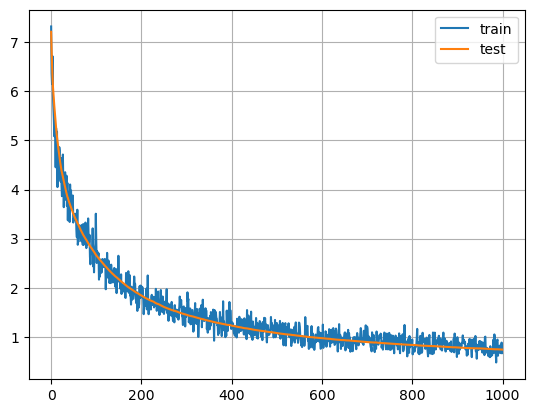

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.grid()
plt.show()

## 2. 은닉층 3개
3계층 신경망 구현 및 실험

In [10]:
class ThreeLayerNet:
    def __init__(self, I, H1, H2, O):
        self.params = {}
        self.params['w1'] = np.random.randn(I, H1)
        self.params['b1'] = np.random.randn(H1)
        self.params['w2'] = np.random.randn(H1, H2)
        self.params['b2'] = np.random.randn(H2)
        self.params['w3'] = np.random.randn(H2, O)
        self.params['b3'] = np.random.randn(O)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['w3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for i in self.layers.values():
            x = i.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1:
            t = np.argmax(t, axis = 1)
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for i in layers:
            dout = i.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        grads['w3'] = self.layers['Affine3'].dw
        grads['b3'] = self.layers['Affine3'].db
        return grads

In [22]:
import pickle
f = open("Data/mnist.dat", 'rb')
train, test = pickle.load(f)
f.close()

train_x, train_y = train
test_x, test_y = test

train_scaled = train_x.reshape(-1, 28*28) / 255
test_scaled = test_x.reshape(-1, 28*28) / 255

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_y = encoder.fit_transform(train_y.reshape(-1, 1)).toarray()
test_y = encoder.fit_transform(test_y.reshape(-1, 1)).toarray()

train_size = len(train_scaled)
batch_size = 1000            # 학습이 너무 안된경우 batch크기를 늘려서 정확도를 높일 수 있음
lr = 0.1

net = ThreeLayerNet(784, 50, 50, 10)        # 첫번째 은닉층 50개, 두번째 은닉층 50개

train_losses = []
test_losses = []

train_acc = []
test_acc = []

In [23]:
for i in range(1, 5001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    for key in ('w1', 'b1', 'w2', 'b2', 'w3', 'b3'):
        net.params[key] -= grad[key] * lr

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 1000 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

1000회 학습 / 정확도(훈련) : 0.547, 정확도(시험) : 0.550
2000회 학습 / 정확도(훈련) : 0.658, 정확도(시험) : 0.661
3000회 학습 / 정확도(훈련) : 0.737, 정확도(시험) : 0.743
4000회 학습 / 정확도(훈련) : 0.813, 정확도(시험) : 0.816
5000회 학습 / 정확도(훈련) : 0.843, 정확도(시험) : 0.842


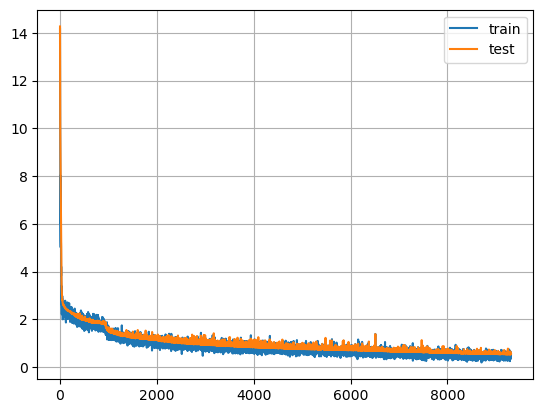

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.grid()
plt.show()

## 연습문제풀이

In [26]:
class TwoLayerNet:
    def __init__(self, I, H, O):
        self.params = {}
        self.params['w1'] = np.random.randn(I, H)
        self.params['b1'] = np.random.randn(H)
        self.params['w2'] = np.random.randn(H, O)
        self.params['b2'] = np.random.randn(O)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Relu'] = Relu()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for i in self.layers.values():
            x = i.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1:
            t = np.argmax(t, axis = 1)
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for i in layers:
            dout = i.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        return grads

# 학습률
딥러닝 모델 학습에 있어 '학습률(Learning Rate)'은 모델의 성능과 학습 속도를 결정하는 가장 중요한 하이퍼파라미터 중 하나입니다. 학습률은 모델이 학습 과정에서 가중치(weight)를 얼마나 크게 업데이트할지를 제어하며, 손실 함수(loss function)를 최소화하는 최적의 가중치를 찾아가는 과정에 직접적인 영향을 미칩니다.

## 확률적 경사 하강법(Stochastic Gradient Descent, SGD)
모델의 학습 가능한 파라미터(params)와 해당 파라미터에 대한 손실 함수의 기울기(grads)를 입력받아, 설정된 학습률(self.lr)을 사용하여 파라미터를 업데이트하는 기능을 수행합니다.

In [27]:
class SGD:
    def __init__(self, lr = 0.1):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= grads[key] * self.lr

In [29]:
train_size = len(train_scaled)
batch_size = 100

optimizer = SGD()

train_size = len(train_scaled)
batch_size = 100
lr = 0.1

net = TwoLayerNet(784, 50, 10)

train_losses = []
test_losses = []

train_acc = []
test_acc = []


for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    # for key in ('w1', 'b1', 'w2', 'b2'):         # 확률적 경사하강법을 만들어 놔서 이부분을 지우면 됨
    #     net.params[key] -= grad[key] * lr 

    params = net.params                            # 이부분 추가됨
    optimizer.update(params, grad)
    
    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 100 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

100회 학습 / 정확도(훈련) : 0.678, 정확도(시험) : 0.684
200회 학습 / 정확도(훈련) : 0.710, 정확도(시험) : 0.717
300회 학습 / 정확도(훈련) : 0.749, 정확도(시험) : 0.758
400회 학습 / 정확도(훈련) : 0.762, 정확도(시험) : 0.763
500회 학습 / 정확도(훈련) : 0.775, 정확도(시험) : 0.777
600회 학습 / 정확도(훈련) : 0.779, 정확도(시험) : 0.787
700회 학습 / 정확도(훈련) : 0.782, 정확도(시험) : 0.790
800회 학습 / 정확도(훈련) : 0.772, 정확도(시험) : 0.777
900회 학습 / 정확도(훈련) : 0.799, 정확도(시험) : 0.802
1000회 학습 / 정확도(훈련) : 0.765, 정확도(시험) : 0.768


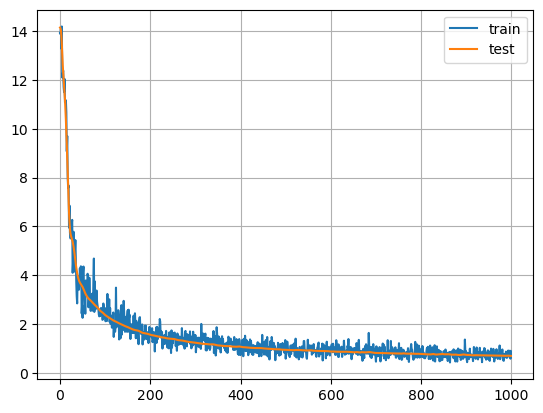

In [32]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.grid()
plt.show()

## 모멘텀(Momentum)
모멘텀은 경사 하강법에 '관성' 개념을 도입한 것으로, 이전에 이동했던 방향의 관성을 유지하면서 현재 기울기 방향으로 파라미터를 업데이트합니다. 이를 통해 지역 최저점에 덜 갇히고, 최적점으로 가는 길에 진동을 줄여 수렴 속도를 개선하는 효과가 있습니다.

In [30]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum      # 관성 효과 계수 저장
        self.v = None               # 각 파라미터에 대한 속도 저장

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                # 속도가 모두 0.
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] + grads[key]         # 처음에 속도는 0... 0+기울기 니까 기울기 하나만.  0.9 * 기울기 한 걸 속도로 정의
            params[key] -= self.lr * self.v[key]

# 모멘텀을 주면 효과적으로 학습률이 증가한 것처럼 작용하기 때문에 더 빨리 수렴할 가능성이 높아진다

In [31]:
train_size = len(train_scaled)
batch_size = 100

optimizer = Momentum()

train_size = len(train_scaled)
batch_size = 100
lr = 0.1

net = TwoLayerNet(784, 50, 10)

train_losses = []
test_losses = []

train_acc = []
test_acc = []


for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    # for key in ('w1', 'b1', 'w2', 'b2'):         # 모멘텀 만들어 놔서 이부분을 지우면 됨
    #     net.params[key] -= grad[key] * lr 

    params = net.params                            # 이부분 추가됨
    optimizer.update(params, grad)
    
    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 100 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

100회 학습 / 정확도(훈련) : 0.656, 정확도(시험) : 0.662
200회 학습 / 정확도(훈련) : 0.693, 정확도(시험) : 0.699
300회 학습 / 정확도(훈련) : 0.717, 정확도(시험) : 0.722
400회 학습 / 정확도(훈련) : 0.727, 정확도(시험) : 0.731
500회 학습 / 정확도(훈련) : 0.746, 정확도(시험) : 0.752
600회 학습 / 정확도(훈련) : 0.761, 정확도(시험) : 0.766
700회 학습 / 정확도(훈련) : 0.772, 정확도(시험) : 0.777
800회 학습 / 정확도(훈련) : 0.777, 정확도(시험) : 0.782
900회 학습 / 정확도(훈련) : 0.789, 정확도(시험) : 0.796
1000회 학습 / 정확도(훈련) : 0.800, 정확도(시험) : 0.804


## AdaGrad(Adaptive Gradient Algorithm)
AdaGrad는 학습률을 모든 파라미터에 대해 동일하게 적용하는 대신, 각 파라미터마다 과거 기울기의 제곱 값을 누적하여 학습률을 개별적으로 조절하는 방식입니다. 자주 업데이트되는(기울기가 큰) 파라미터는 학습률을 작게 만들고, 드물게 업데이트되는(기울기가 작은) 파라미터는 학습률을 크게 만들어 학습 효율성을 높입니다. 특히 스파스(Sparse)한 데이터에 효과적인 것으로 알려져 있습니다.

In [36]:
# Momentum: 기울기가 크면 더 크게, 작으면 더 작게.
# Adagrad: 기울기가 크면 작게, 작으면 크게.

class AdaGrad:
    def __init__(self, lr = 0.01, epsilon = 1e-8):
        self.lr = lr
        self.epsilon = epsilon
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)     # 0행렬을 momentum처럼 만든다

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]      # 기울기값을 제곱한 값을 key값에 넣는다 
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + self.epsilon)

In [37]:
train_size = len(train_scaled)
batch_size = 100

optimizer = AdaGrad()

train_size = len(train_scaled)
batch_size = 100
lr = 0.1

net = TwoLayerNet(784, 50, 10)

train_losses = []
test_losses = []

train_acc = []
test_acc = []


for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params   
    optimizer.update(params, grad)
    
    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 100 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

100회 학습 / 정확도(훈련) : 0.500, 정확도(시험) : 0.507
200회 학습 / 정확도(훈련) : 0.587, 정확도(시험) : 0.599
300회 학습 / 정확도(훈련) : 0.636, 정확도(시험) : 0.652
400회 학습 / 정확도(훈련) : 0.667, 정확도(시험) : 0.682
500회 학습 / 정확도(훈련) : 0.692, 정확도(시험) : 0.703
600회 학습 / 정확도(훈련) : 0.707, 정확도(시험) : 0.716
700회 학습 / 정확도(훈련) : 0.722, 정확도(시험) : 0.731
800회 학습 / 정확도(훈련) : 0.733, 정확도(시험) : 0.743
900회 학습 / 정확도(훈련) : 0.742, 정확도(시험) : 0.753
1000회 학습 / 정확도(훈련) : 0.750, 정확도(시험) : 0.758


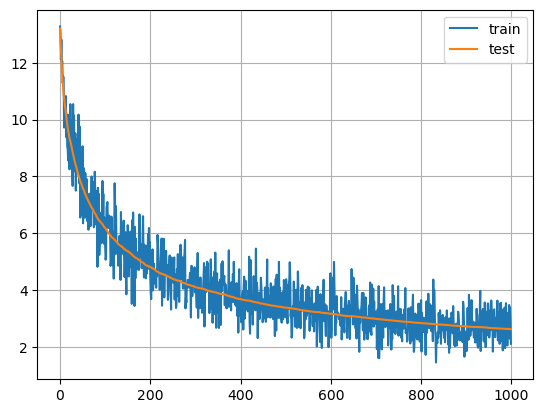

In [38]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.grid()
plt.show()

## Adam(Adaptive Moment Estimation)
Adam은 현재 가장 널리 사용되는 옵티마이저 중 하나로, Momentum과 RMSProp (또는 AdaGrad의 변형)의 장점을 결합한 방식입니다. Adam은 각 파라미터에 대해 다음과 같은 두 가지 이동 평균을 계산하여 사용합니다.

1. 첫 번째 모멘트 (First Moment, m): 기울기의 지수 가중 평균. Momentum의 속도와 유사합니다. (과거 기울기의 방향 정보를 축적)
2. 두 번째 모멘트 (Second Moment, v): 기울기 제곱의 지수 가중 평균. RMSProp의 s 또는 AdaGrad의 h와 유사합니다. (과거 기울기 크기의 정보를 축적하여 학습률 조절)

In [40]:
class Adam:
    # __init__ 메서드: 학습률(lr), beta1, beta2, 엡실론(epsilon)을 인자로 받습니다.
    # self.m: 첫 번째 모멘트 (기울기 평균)를 저장할 딕셔너리
    # self.v: 두 번째 모멘트 (기울기 제곱 평균)를 저장할 딕셔너리
    # self.iter: 업데이트 스텝 카운터 (Bias Correction에 사용)
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.iter = 0 # 학습 횟수 카운터 (Bias Correction에 사용)
        self.m = None # 1차 모멘트 (기울기의 지수 가중 평균)
        self.v = None # 2차 모멘트 (기울기 제곱의 지수 가중 평균)

    # update 메서드: 파라미터(params)와 기울기(grads)를 받아 파라미터를 업데이트합니다.
    def update(self, params, grads):
        # 업데이트 스텝 카운터를 1 증가시킵니다. (Bias Correction 계산에 필요)
        self.iter += 1

        # 첫 번째 업데이트 스텝인 경우, m과 v 딕셔너리를 초기화합니다.
        # 각 파라미터에 대해 m과 v를 0으로 채워진 배열로 초기화합니다.
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        # params 딕셔너리의 모든 키(파라미터)를 순회합니다.
        for key in params.keys():
            # 1. 1차 모멘트 (m) 업데이트: 기울기의 지수 가중 평균 계산
            # m = beta1 * m_prev + (1 - beta1) * gradient
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]

            # 2. 2차 모멘트 (v) 업데이트: 기울기 제곱의 지수 가중 평균 계산 (원소별 제곱)
            # v = beta2 * v_prev + (1 - beta2) * (gradient * gradient)
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2) # np.power(grads[key], 2) 도 가능

            # 3. 1차 모멘트 편향 보정 (Bias Correction for first moment)
            # m_hat = m / (1 - beta1^t)
            m_hat = self.m[key] / (1 - self.beta1**self.iter)

            # 4. 2차 모멘트 편향 보정 (Bias Correction for second moment)
            # v_hat = v / (1 - beta2^t)
            v_hat = self.v[key] / (1 - self.beta2**self.iter)

            # 5. 파라미터 업데이트: Bias-corrected 모멘트들을 사용하여 업데이트 방향과 크기 조절
            # param = param - (lr / (sqrt(v_hat) + epsilon)) * m_hat
            params[key] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

In [ ]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.iter = 0 
        self.m = None
        self.v = None

    def update(self, params, grads):
        self.iter += 1
        
        if self.m is None:
            self.m, self.v = {}, {}
            
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)

            m_hat = self.m[key] / (1 - self.beta1**self.iter)
            v_hat = self.v[key] / (1 - self.beta2**self.iter)
            
            params[key] -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

## 연습문제
1. SGD, Momentum, AdaGrad, Adam을 복습하고, 각각 학습 진도 그래프를 시각화해서 비교해보세요.

In [41]:
# 훈련세트만 각 4개의 최적화 함수 학습 진도 그래프 그리기
# 어떤 것이 가장 좋게 나오는지 시각화

optimizers = {
    "SGD": SGD(),
    "Momentum": Momentum(),
    "AdaGrad": AdaGrad(),
    "Adam": Adam()
}

train_size = len(train_scaled)
batch_size = 100
lr = 0.1
iterations = 1000

loss_dict = {}

for key in optimizers:
    print(f"\n===== {key} 학습 시작 =====")
    optimizer = optimizers[key]
    net = TwoLayerNet(784, 50, 10)
    train_losses = []

    for i in range(1, iterations + 1):
        mask = np.random.choice(train_size, batch_size)
        x_batch = train_scaled[mask]
        t_batch = train_y[mask]

        grads = net.gradient(x_batch, t_batch)
        optimizer.update(net.params, grads)

        loss = net.loss(x_batch, t_batch)
        train_losses.append(loss)

        if i % 100 == 0:
            acc = net.accuracy(train_scaled, train_y)
            print(f"{i}회 학습 / 훈련 정확도 : {acc:.4f}")
    
    loss_dict[key] = train_losses


===== SGD 학습 시작 =====
100회 학습 / 훈련 정확도 : 0.6859
200회 학습 / 훈련 정확도 : 0.7275
300회 학습 / 훈련 정확도 : 0.7325
400회 학습 / 훈련 정확도 : 0.7561
500회 학습 / 훈련 정확도 : 0.7265
600회 학습 / 훈련 정확도 : 0.7688
700회 학습 / 훈련 정확도 : 0.7816
800회 학습 / 훈련 정확도 : 0.7660
900회 학습 / 훈련 정확도 : 0.7661
1000회 학습 / 훈련 정확도 : 0.7958

===== Momentum 학습 시작 =====
100회 학습 / 훈련 정확도 : 0.6774
200회 학습 / 훈련 정확도 : 0.7004
300회 학습 / 훈련 정확도 : 0.7206
400회 학습 / 훈련 정확도 : 0.7171
500회 학습 / 훈련 정확도 : 0.7251
600회 학습 / 훈련 정확도 : 0.7547
700회 학습 / 훈련 정확도 : 0.7654
800회 학습 / 훈련 정확도 : 0.7625
900회 학습 / 훈련 정확도 : 0.7781
1000회 학습 / 훈련 정확도 : 0.7803

===== AdaGrad 학습 시작 =====
100회 학습 / 훈련 정확도 : 0.4808
200회 학습 / 훈련 정확도 : 0.5764
300회 학습 / 훈련 정확도 : 0.6220
400회 학습 / 훈련 정확도 : 0.6526
500회 학습 / 훈련 정확도 : 0.6741
600회 학습 / 훈련 정확도 : 0.6889
700회 학습 / 훈련 정확도 : 0.6996
800회 학습 / 훈련 정확도 : 0.7094
900회 학습 / 훈련 정확도 : 0.7196
1000회 학습 / 훈련 정확도 : 0.7270

===== Adam 학습 시작 =====
100회 학습 / 훈련 정확도 : 0.3493
200회 학습 / 훈련 정확도 : 0.5060
300회 학습 / 훈련 정확도 : 0.5994
400회 학습 / 훈련 정확도 : 0.6544
500회 학습 / 훈

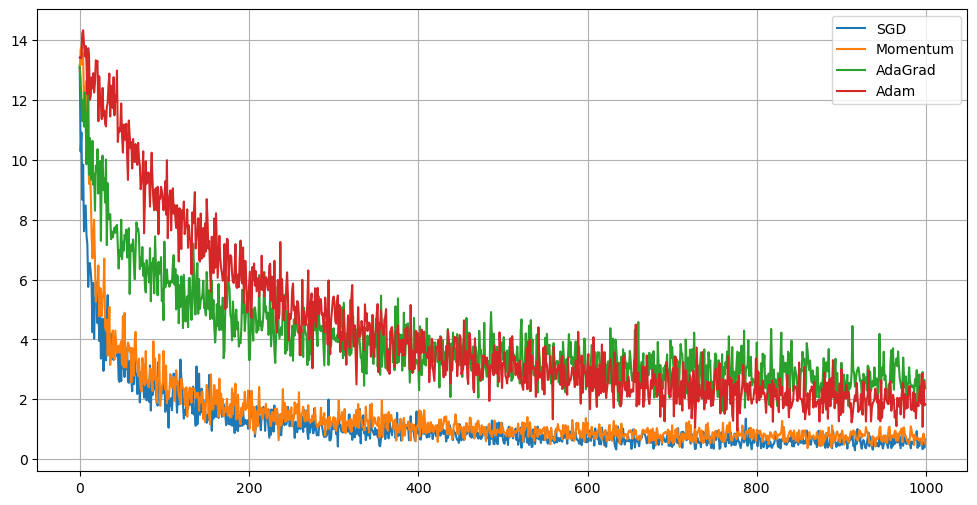

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for key, losses in loss_dict.items():
    plt.plot(range(len(losses)), losses, label=key)
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# 강사님풀이

train_size = len(train_scaled)
batch_size = 100

optimizer = SGD()

train_size = len(train_scaled)
batch_size = 100
lr = 0.1

net = TwoLayerNet(784, 50, 10)

train_losses1 = []

for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params   
    optimizer.update(params, grad)
    
    loss = net.loss(x_batch, t_batch)

    train_losses1.append(loss)

In [50]:
train_size = len(train_scaled)
batch_size = 100

optimizer = Momentum()

train_size = len(train_scaled)
batch_size = 100
lr = 0.1

net = TwoLayerNet(784, 50, 10)

train_losses2 = []

for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params   
    optimizer.update(params, grad)
    
    loss = net.loss(x_batch, t_batch)

    train_losses2.append(loss)

In [51]:
train_size = len(train_scaled)
batch_size = 100

optimizer = AdaGrad()

train_size = len(train_scaled)
batch_size = 100
lr = 0.1

net = TwoLayerNet(784, 50, 10)

train_losses3 = []

for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params   
    optimizer.update(params, grad)
    
    loss = net.loss(x_batch, t_batch)

    train_losses3.append(loss)

In [52]:
train_size = len(train_scaled)
batch_size = 100

optimizer = Adam()

train_size = len(train_scaled)
batch_size = 100
lr = 0.1

net = TwoLayerNet(784, 50, 10)

train_losses4 = []

for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    params = net.params   
    optimizer.update(params, grad)
    
    loss = net.loss(x_batch, t_batch)

    train_losses4.append(loss)

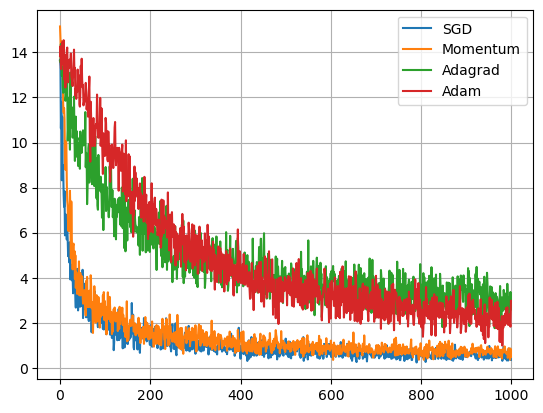

In [53]:
import matplotlib.pyplot as plt

plt.plot(train_losses1)
plt.plot(train_losses2)
plt.plot(train_losses3)
plt.plot(train_losses4)
plt.legend(["SGD", "Momentum", "Adagrad", "Adam"])
plt.grid()
plt.show()

# 장기적으로 봤을 때 Adam이 좋다

# 가중치의 초기 값

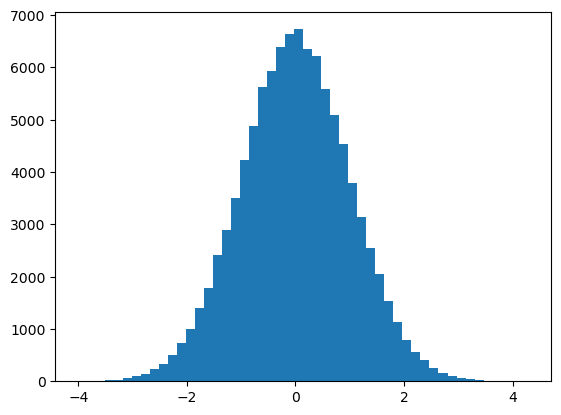

In [60]:
x = np.random.randn(1000, 100)

plt.hist(x.flatten(), bins = 50)
# plt.grid()
plt.show()

In [72]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
hidden_layers = 5       # 은닉층 5개
activations = {}        

for i in range(hidden_layers):
    if i != 0:
        x = activations[i-1]      # 처음에는 x값그대로 쓰다가, 통과된 값으로 x에 덧붙여서 계속 사용
    w = np.random.randn(100, 100) / np.sqrt(100)
    a = x @ w
    z = sigmoid(a)
    activations[i] = z

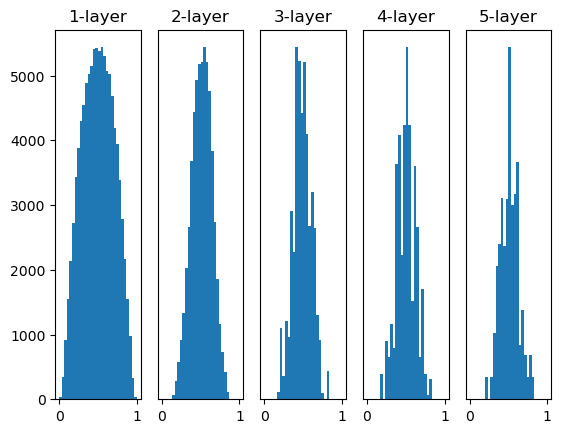

In [74]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0, 1))

plt.show()

# 대부분의 값들이 0, 1에 치우처져있음.  
# => 가중치를 랜덤으로 주는게 항상 좋은 방법은 아니다

# w애 * 0.01 하면 0.5에 가깝게 나옴 => sigmoid(1) = 0.5라서?

# w에 / 루트100 하면 데이터를 나름 다채롭게 표시 가능 = 자비에르 초기값

## Xavier 초기값

In [75]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
hidden_layers = 5       # 은닉층 5개
activations = {}        

for i in range(hidden_layers):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(100, 100) / np.sqrt(100)         # 나누기 루트100
    a = x @ w
    z = sigmoid(a)
    activations[i] = z

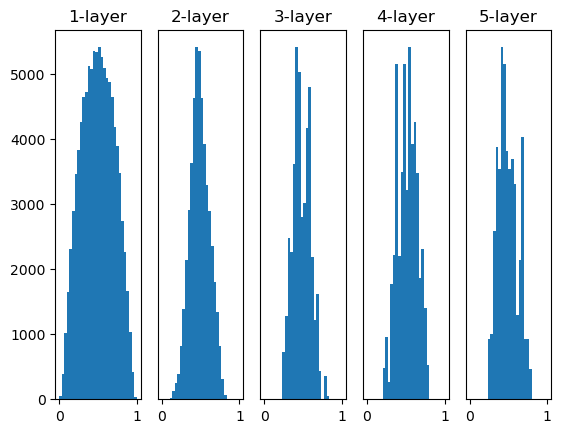

In [76]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0, 1))

plt.show()

## He 초기값: 렐루에 특화된 초기값

In [81]:
def relu(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
hidden_layers = 5       # 은닉층 5개
activations = {}        

for i in range(hidden_layers):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(100, 100) * np.sqrt(2 / 100)       # 곱하기 루트 2/100
    a = x @ w
    z = relu(a)
    activations[i] = z

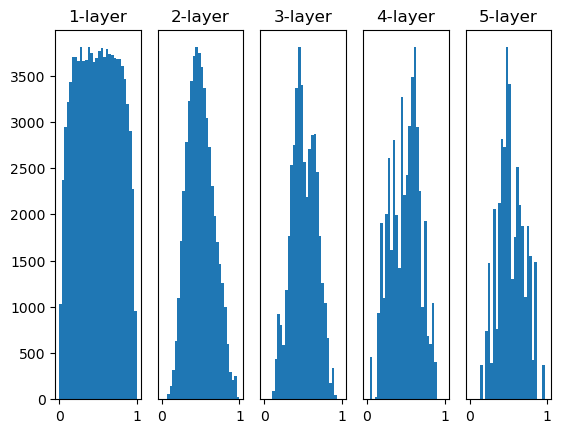

In [80]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    if i != 0:
        plt.yticks([], [])
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range = (0, 1))

plt.show()

### He초기값 활용한 코드

In [ ]:
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, I, H, O):
        
        a = np.sqrt(2 / (I + H))                               # 추가
        self.params = {}
        self.params['w1'] = np.random.randn(I, H) * a                # * a 추가됨 
        self.params['b1'] = np.random.randn(H)
        self.params['w2'] = np.random.randn(H, O)
        self.params['b2'] = np.random.randn(O)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['w1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['w2'], self.params['b2'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for i in self.layers.values():
            x = i.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1:
            t = np.argmax(t, axis = 1)
        accuracy = np.sum(y == t) / x.shape[0]
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for i in layers:
            dout = i.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
        return grads

In [82]:
import pickle
f = open("Data/mnist.dat", 'rb')
train, test = pickle.load(f)
f.close()

train_x, train_y = train
test_x, test_y = test

train_scaled = train_x.reshape(-1, 28*28) / 255
test_scaled = test_x.reshape(-1, 28*28) / 255

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_y = encoder.fit_transform(train_y.reshape(-1, 1)).toarray()
test_y = encoder.fit_transform(test_y.reshape(-1, 1)).toarray()

train_size = len(train_scaled)
batch_size = 100
lr = 0.1

net = TwoLayerNet(784, 50, 10)

train_losses = []
test_losses = []

train_acc = []
test_acc = []

for i in range(1, 1001):
    mask = np.random.choice(train_size, batch_size)
    x_batch = train_scaled[mask]
    t_batch = train_y[mask]

    grad = net.gradient(x_batch, t_batch)

    for key in ('w1', 'b1', 'w2', 'b2'):
        net.params[key] -= grad[key] * lr

    loss = net.loss(x_batch, t_batch)
    test_loss = net.loss(test_scaled, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

    if i % 100 == 0:
        a = net.accuracy(train_scaled, train_y)
        b = net.accuracy(test_scaled, test_y)
        train_acc.append(a)
        test_acc.append(b)
        print(f"{i}회 학습 / 정확도(훈련) : {a:.3f}, 정확도(시험) : {b:.3f}")

100회 학습 / 정확도(훈련) : 0.699, 정확도(시험) : 0.714
200회 학습 / 정확도(훈련) : 0.752, 정확도(시험) : 0.761
300회 학습 / 정확도(훈련) : 0.768, 정확도(시험) : 0.770
400회 학습 / 정확도(훈련) : 0.762, 정확도(시험) : 0.765
500회 학습 / 정확도(훈련) : 0.785, 정확도(시험) : 0.790
600회 학습 / 정확도(훈련) : 0.782, 정확도(시험) : 0.786
700회 학습 / 정확도(훈련) : 0.783, 정확도(시험) : 0.783
800회 학습 / 정확도(훈련) : 0.794, 정확도(시험) : 0.802
900회 학습 / 정확도(훈련) : 0.811, 정확도(시험) : 0.819
1000회 학습 / 정확도(훈련) : 0.808, 정확도(시험) : 0.814


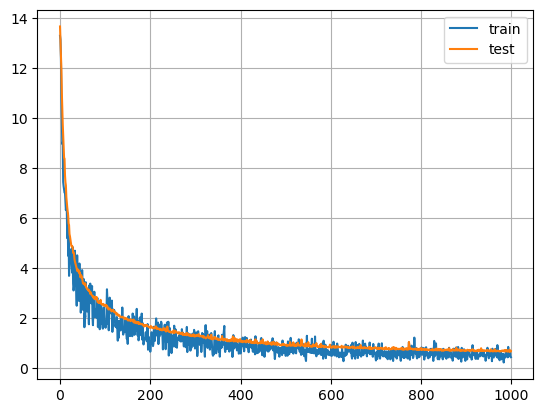

In [83]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label = 'train')
plt.plot(test_losses, label = 'test')
plt.legend()
plt.grid()
plt.show()

# 라이브러리로

In [1]:
# Tensorflow : Google 
# Pytorch : Facebook (이미지 검출)